In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing


In [2]:
path = './AirPassengers.csv'

In [3]:
df = pd.read_csv(path, index_col='Month', parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df = df.rename(columns= {'#Passengers':'y'})

In [5]:
df.columns

Index(['y'], dtype='object')

In [6]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [7]:
df = df.asfreq('MS')

In [8]:
df.head(10)

,y
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [9]:
df.isnull().sum()

y    0
dtype: int64

## Visualization

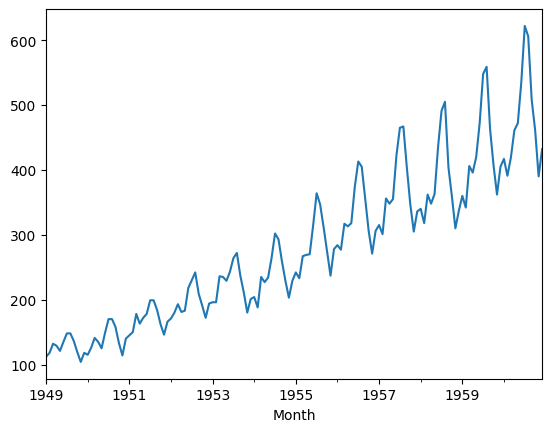

In [10]:
df['y'].plot()
plt.show()

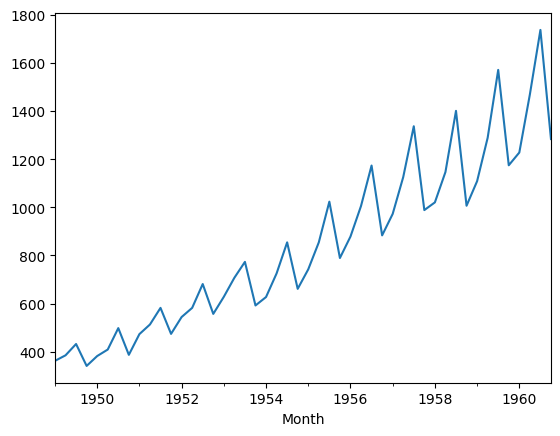

In [12]:
df.resample('QE').sum()['y'].plot()
plt.show()

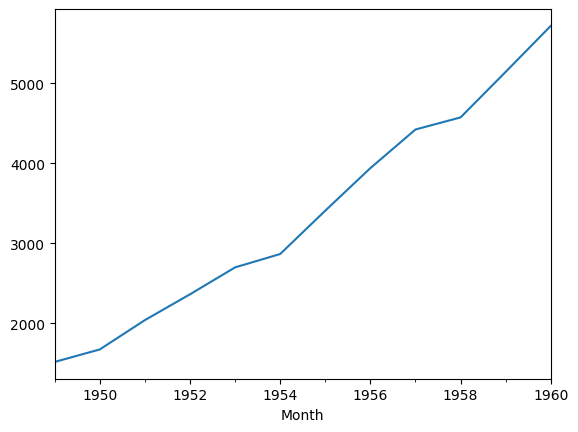

In [13]:
df.resample('YE').sum()['y'].plot()
plt.show()

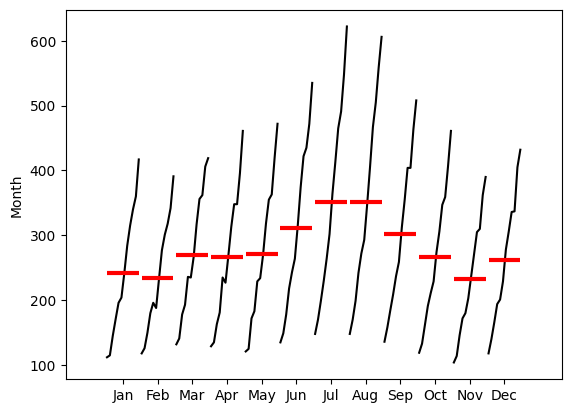

In [17]:
# seasonal samplings
month_plot(df['y'].resample('MS').mean(), ylabel='Month')
plt.show()

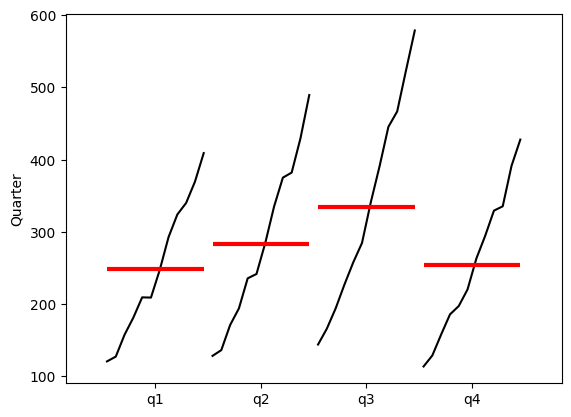

In [18]:
quarter_plot(df['y'].resample('QS').mean(), ylabel='Quarter')
plt.show()

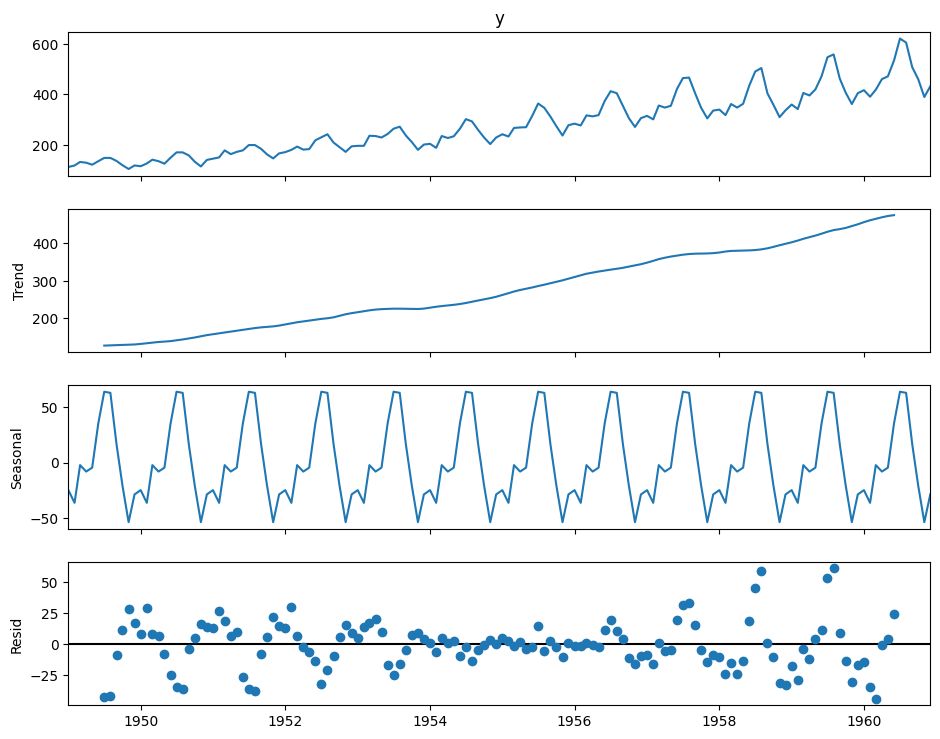

In [20]:
decomposition = seasonal_decompose(df['y'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

## Auto Correlations

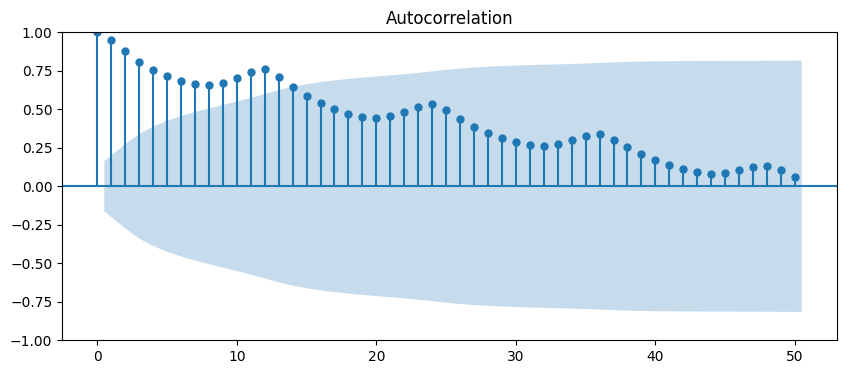

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df['y'], lags=50, ax=ax)
plt.show()

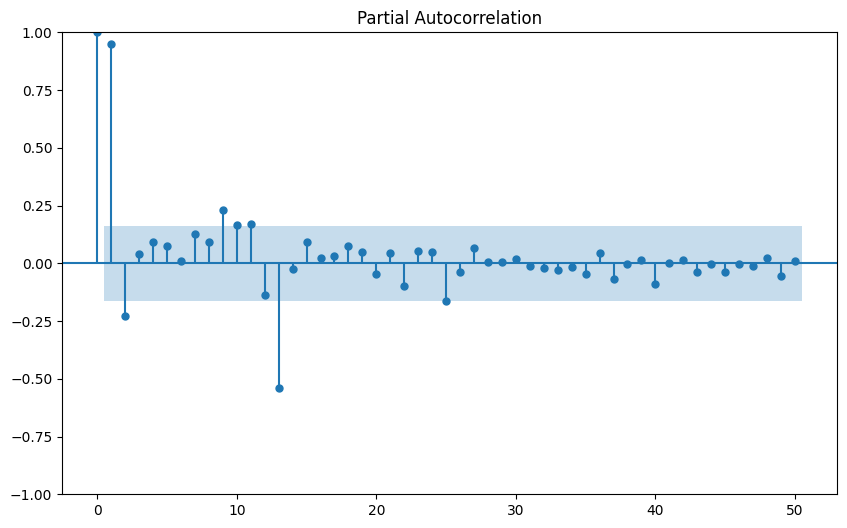

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(df['y'], lags=50, ax=ax)
plt.show()

# Model list
- Exponential model
- ARIMA/SARIMA
- Prophet

In [41]:
periods = 10
train, test = df.iloc[:-periods], df.iloc[-periods:]
test.head()

,y
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622


In [42]:
def model_assessment(train, test, prediction ,title):
    plt.figure(figsize=(10, 6))
    plt.plot(train, label='train')
    plt.plot(test, label='test')
    plt.plot(prediction, label='Forecast')
    plt.title(f"Train, test and forecast of {title}")
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, prediction)
    rmse = root_mean_squared_error(test, prediction)
    mape = mean_absolute_percentage_error(test, prediction)

    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.3f}")

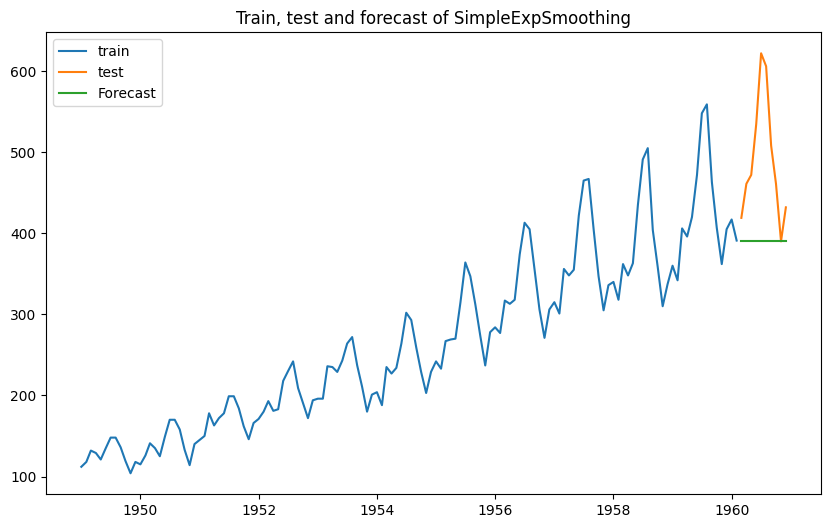

MAE: 99.800
RMSE: 123.628
MAPE: 0.187


In [43]:
model_simple = SimpleExpSmoothing(train).fit()
prediction_simple = model_simple.forecast(len(test))
model_assessment(train, test, prediction_simple, 'SimpleExpSmoothing')

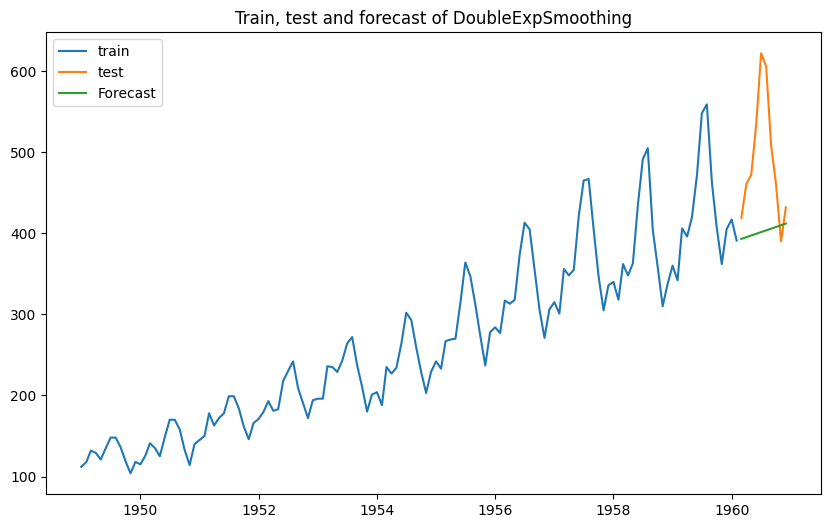

MAE: 92.038
RMSE: 115.180
MAPE: 0.172


In [48]:
model_double = ExponentialSmoothing(train, trend="add", seasonal=None).fit()
prediction_double = model_double.forecast(len(test))
model_assessment(train, test, prediction_double, "DoubleExpSmoothing")

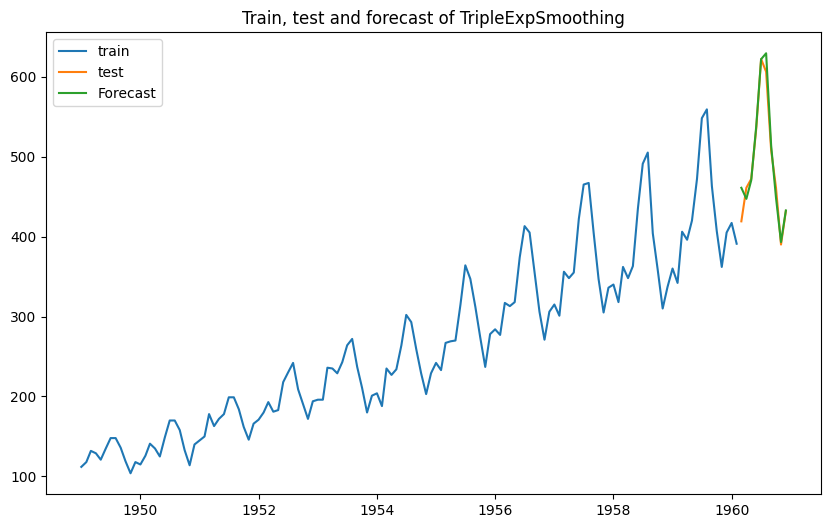

MAE: 10.612
RMSE: 16.436
MAPE: 0.023


In [55]:
model_triple = ExponentialSmoothing(train, trend='add', seasonal='mul').fit()
prediction_triple = model_triple.forecast(len(test))
model_assessment(train, test, prediction_triple, "TripleExpSmoothing")

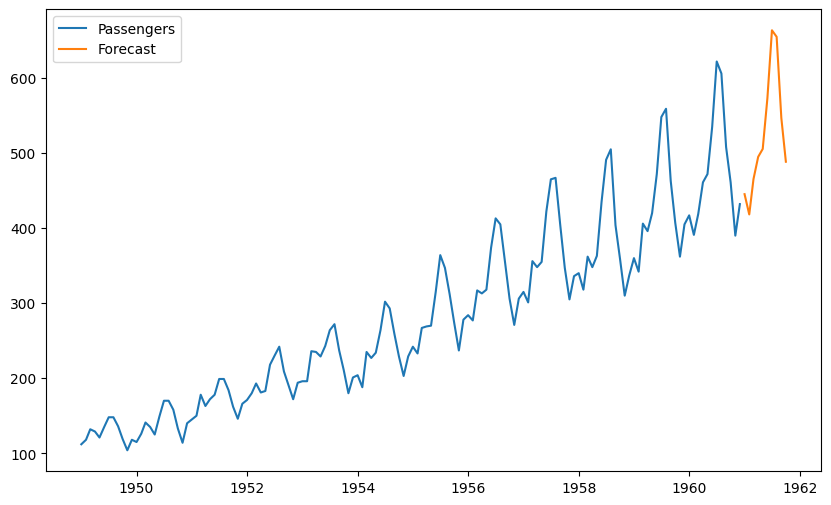

In [56]:
model = ExponentialSmoothing(df['y'], trend='add', seasonal='mul').fit()
prediction = model.forecast(10)
plt.figure(figsize=(10,6))
plt.plot(df['y'], label='Passengers')
plt.plot(prediction, label='Forecast')
plt.legend()
plt.show()